In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import torch.optim as optim
import scipy


In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
class swapaxis(object):
    
    def __init__(self):
        pass
    def __call__(self, sample):
       # sample = torch.permute(sample,(self.first,self.second,self.third))
        sample = np.swapaxes(np.swapaxes(sample.numpy(), 0, 2), 0, 1)
        return sample

    def __repr__(self):
        return self.__class__.__name__+'()'

class label(object):
    def __call__(self,sample):
        return 10

In [4]:
size = 32
batch_size = 128


train_digits_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                    transforms.Grayscale(num_output_channels=3),
                                    transforms.ToTensor(),
                                     ])
test_digits_transform = transforms.Compose([transforms.Resize((size, size)),
#                                    transforms.Grayscale(num_output_channels=3),
                                    transforms.ToTensor(),

                                    ])

train_cifar_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor(),

                                     ])

In [5]:
train_cifar = datasets.CIFAR10(root = 'cifar', train = True,transform = train_cifar_transform
                              ,target_transform = label(),download = True)
test_cifar  = datasets.CIFAR10(root = 'cifar', train = False,transform = train_cifar_transform
                              ,target_transform = label(),download = True)



train_digits = datasets.SVHN(root = 'SVHN',split = 'train',transform = train_digits_transform
                             ,download = True)
test_digits  = datasets.SVHN(root = 'SVHN',split = 'test', transform = test_digits_transform
                             ,download = True)




Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: SVHN/train_32x32.mat
Using downloaded and verified file: SVHN/test_32x32.mat


In [6]:
for index,value in enumerate(train_cifar.targets):
    if index < 10:
        train_cifar.targets[index] = index
    else:
        train_cifar.targets[index] = 10

In [7]:
for index,vallue in enumerate(test_cifar.targets):
    test_cifar.targets[index] = 10

### Segmenting a smaller portion of cifar dataset for concatinating with our original dataset

In [8]:
### using aournd 10% of the original trainset size which is approx 7,325 pictures
extra_training_data = []
extra_testing_data  = []
for i in range(7325):
    extra_training_data.append(train_cifar[i])

### doing the same for the testing data 

for i in range(2500):
    extra_testing_data.append(test_cifar[i])

### Visualizing the data

In [9]:
train_dataset= train_digits+extra_training_data
test_dataset = test_digits+extra_testing_data

In [10]:
print(f"labels for SVHN: {np.unique(train_digits.labels)}")
print(f"classes for cifar: {np.unique(test_cifar.targets)}")

labels for SVHN: [0 1 2 3 4 5 6 7 8 9]
classes for cifar: [10]


In [11]:
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
print(train_loader)

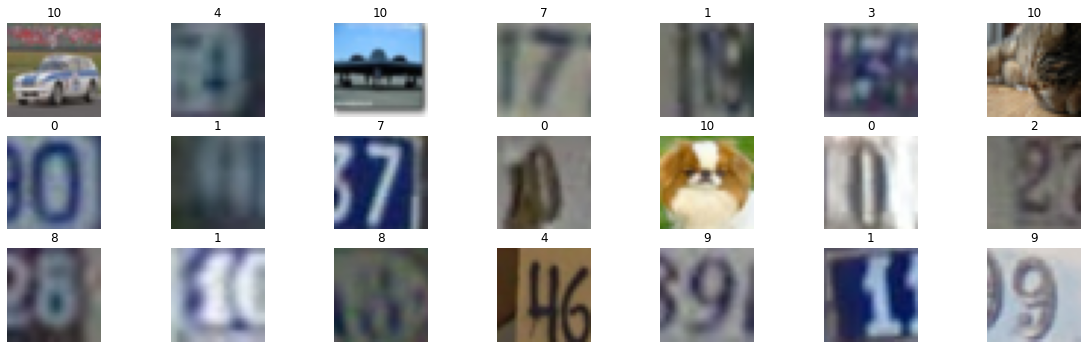

In [12]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1),cmap="gray")
    plt.title(labels[i].item())
    plt.axis('off')

In [13]:
### Defaults to no pretrained weights, so randomly initilized
model = models.mobilenet_v3_large()

### Changing the last layer to be 10 instead of 1000
model.classifier[3] = nn.Linear(1280,11,bias=True)

model = model.to(device)

In [14]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [15]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=3):
    #def loss_fun(output, target):
    #    return F.nll_loss(torch.log(output), target)
    loss_fun = nn.CrossEntropyLoss()
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)            
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        
        
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(train_dataset))
        out_dict['test_acc'].append(test_correct/len(test_dataset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [16]:
model_trained = train(model, optimizer, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/630 [00:00<?, ?it/s]

Loss train: 1.114	 test: 1.115	 Accuracy train: 63.3%	 test: 71.6%


  0%|          | 0/630 [00:00<?, ?it/s]

Loss train: 0.505	 test: 0.532	 Accuracy train: 84.4%	 test: 83.8%


  0%|          | 0/630 [00:00<?, ?it/s]

Loss train: 0.392	 test: 0.429	 Accuracy train: 88.1%	 test: 87.4%


  0%|          | 0/630 [00:00<?, ?it/s]

Loss train: 0.346	 test: 0.424	 Accuracy train: 89.6%	 test: 87.2%


  0%|          | 0/630 [00:00<?, ?it/s]

Loss train: 0.305	 test: 0.381	 Accuracy train: 90.7%	 test: 89.1%


Text(0, 0.5, 'Loss')

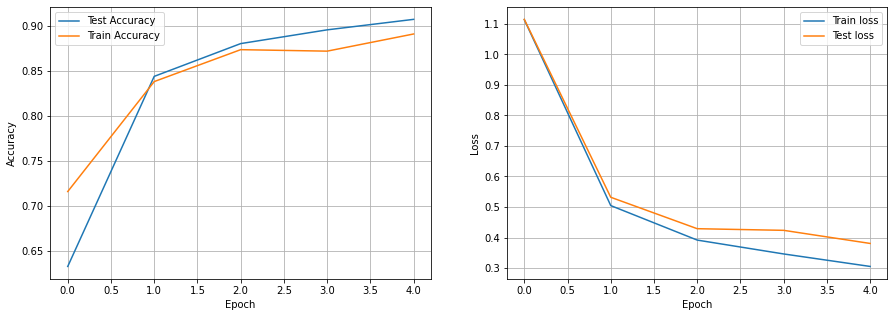

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

ax[0].plot(model_trained['train_acc'], label='train')
ax[0].plot(model_trained['test_acc'], label='test')
ax[0].grid()
ax[0].legend(('Test Accuracy','Train Accuracy'))
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

### plot number 2
ax[1].plot(model_trained['train_loss'], label='train')
ax[1].plot(model_trained['test_loss'], label='test')
ax[1].legend(('Train loss','Test loss'))
ax[1].grid()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

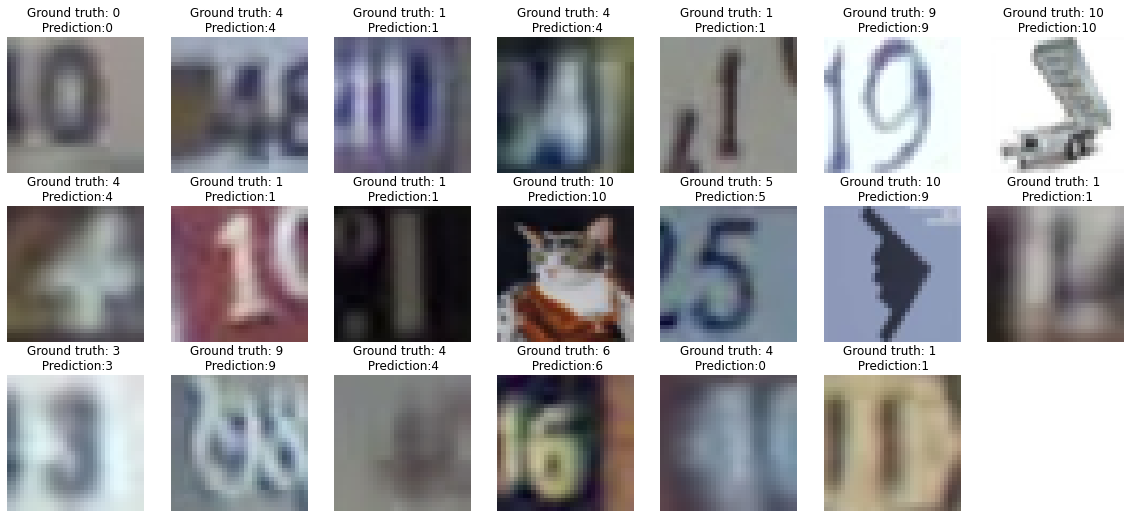

In [19]:
images, labels = next(iter(test_loader))


data = images.to(device)
with torch.no_grad():
    output = model(data)
    predicted = output.argmax(1)
    
plt.figure(figsize=(20,15))

for i in range(20):
    plt.subplot(5,7,i+1)

    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    
    plt.title(f'Ground truth: {labels[i]} \n Prediction:{predicted[i].item()}')
    plt.axis('off')


In [357]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from itertools import product
import math
inference_transform = transforms.Compose([  
                                    transforms.ToTensor()])

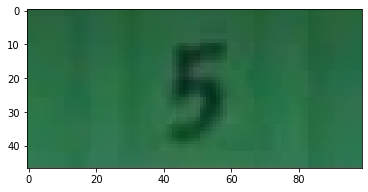

In [479]:
image = Image.open('1.png')
plt.imshow(image)

In [481]:
w, h =image.size
expected_input_size = 32
stride = 5

columns = math.floor((w-(expected_input_size))/stride)
rows    = math.floor((h-(expected_input_size))/stride)

boxes = []
images = []

for i in range(columns):
    for j in range(rows):
        box = ((i*1)*stride,(j*1)*stride , (i*1)*stride+32,(j*1)*stride+32)
        boxes.append(box)
        images.append(image.crop(box))

In [482]:
tensors = []
for index, image in enumerate(images):
    tensors.append(inference_transform(image))

In [483]:
inference_loader = DataLoader(tensors, batch_size=len(tensors))

In [486]:
images = next(iter(inference_loader))

data = images.to(device)
with torch.no_grad():
    output = model(data)
    predicted = output.argmax(1)

output= output.cpu().numpy()
confidence = []

for index,tensor in enumerate(output):
    confidence.append(tensor[np.argmax(tensor)])

max_index = np.argmax(confidence)
max_value = max(confidence)


In [494]:
from PIL import Image, ImageDraw

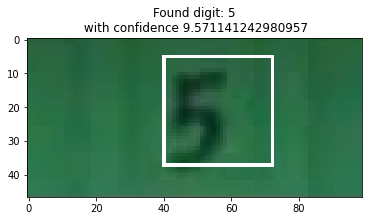

In [537]:
import matplotlib.patches as patches

img = Image.open('1.png')

# create rectangle image
img1 = ImageDraw.Draw(img)  
img1.rectangle(boxes[max_index])
img.show()
plt.title(f"Found digit: {predicted[max_index]}\n with confidence {max_value}")
plt.imshow(img)

### Til fremtids victor

Sørg for at den treshholder og ikke bare tager den største værdi så vi kan have flere boxes hvis der er flere digits

Find ud af at lav mere complex algo istedet for bare at choppe billedet og køre det igennem en masse gange